In [29]:
import bisect
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
# import pydot
from google.cloud import storage

import dalmatian 
import model_helper 
from helper import *
from scipy.stats import iqr

In [2]:
# Load wbc and treatment file 
wbc_file = 'CRC-0040_wbc.txt'
treatment = pd.read_csv("CRC_0040.txt", sep = '\t')

# Get input files from Terra through dalmatian
patient = 'CLL-CRC-0040'
workspace ='broad-firecloud-ibmwatson/Getz-IBM-Wu_Fludarabine_Resistance-Analysis'
wm = dalmatian.WorkspaceManager(workspace)
participants = wm.get_participants()

cluster_CCF_df = pd.read_csv(participants.loc[patient]['cluster_ccfs_Aug2'], sep='\t')
participants = wm.get_participants()
abundance_df = pd.read_csv(participants.loc[patient]['abundances_tsv_Aug2'], sep='\t')
mcmc_df = pd.read_csv(participants.loc[patient]['cell_population_mcmc_trace_Aug2'], sep='\t')
tree_df = pd.read_csv(participants.loc[patient]['tree_tsv_Aug2'], sep='\t')

In [3]:
times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others = model_helper.load_wbc_file(wbc_file)

In [4]:
def select_wbc(dfd, times, wbc, times_sample):
    '''
    select wbc until the first treatment after last sequencing sample

    Args:
        dfd: first treatment dfd after last sequencing sample
    
    '''
    last_sample_time = times_sample[-1]

    times_selected = [time_ for time_ in times if time_ <= dfd]

    smallest_times_selected = max(times_selected)

    smallest_index = times.index(smallest_times_selected)

    wbc_selected = wbc[0: smallest_index+ 1]

    return times_selected, wbc_selected

In [5]:
# Acalabrutinib started on 4324
times_selected, wbc_selected = select_wbc(4324, times, wbc, times_sample)

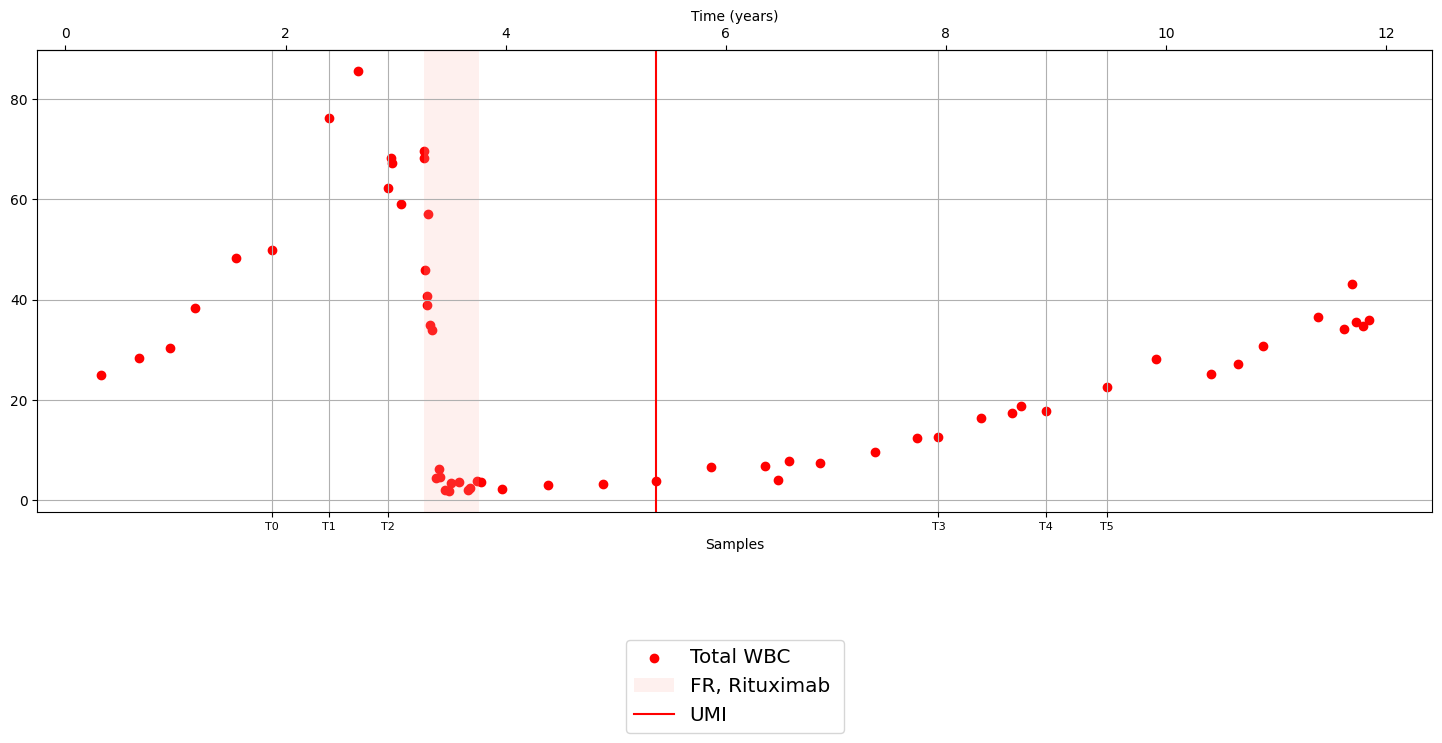

In [6]:
fig,ax = plt.subplots(1,1, figsize=(18,6))

number_samples = len(sample_list)
tick_list = ['T'+ str(i) for i in range(number_samples)]

x_year = [ i/365 for i in np.array(times_selected)]
ax.scatter(x_year,wbc_selected, label = 'Total WBC', c = 'red')
plt.yscale("linear")
x_axis = [i/365 for i in times_sample]
ax.set_xticks(x_axis)

ax.set_xticklabels(tick_list, fontsize =8)
secax = ax.secondary_xaxis('top')
secax.set_xlabel("Time (years)")
ax.grid(True)


cmap = plt.get_cmap("Pastel1")
xlim = ax.get_xlim()[1]

for i, row in treatment.iterrows():
    treatment_name = row.tx
    start = row.tx_start/365
    end = row.tx_end/365
    if np.isnan(end):
        end = xlim
    length = end - start 
    center = (start + end)/2
#         color = color_dict[treatment_name]
    ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
    ax.set_xlabel('Samples')

# add potential UMI samples
ax.axvline(x=1958/365, label ='UMI', color = 'red')

ax.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.5),fontsize = 'x-large')


Subclonal modeling

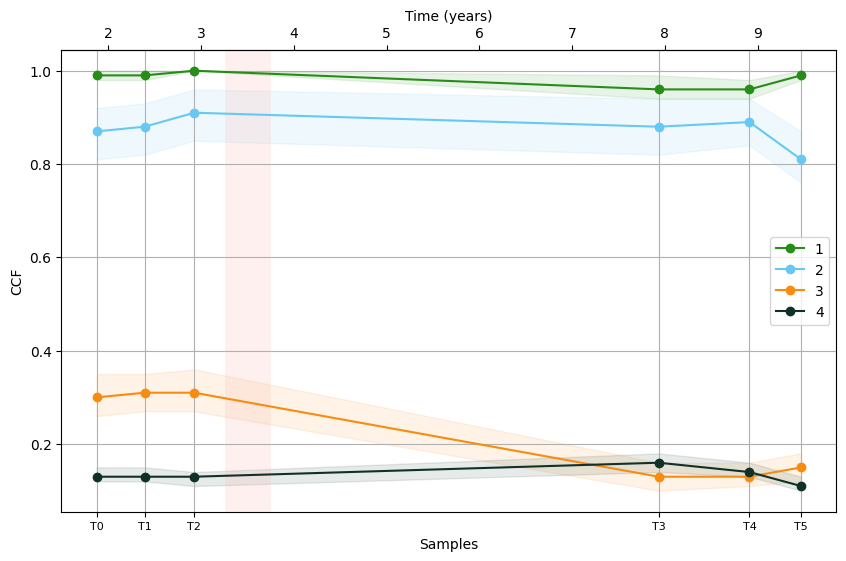

In [7]:
fig, ax = plt.subplots(figsize = (10, 6))
model_helper.plot_ccf(cluster_CCF_df,ax, times_sample, treatment)

In [7]:
cluster_list, cluster_abundance = model_helper.get_abundance(abundance_df, mcmc_df, sample_list)

In [8]:
cluster_abundance

{1: [0.12, 0.09, 0.08, 0.05, 0.1, 0.21],
 2: [0.44, 0.49, 0.5, 0.63, 0.58, 0.5],
 3: [0.3, 0.28, 0.3, 0.12, 0.15, 0.17],
 4: [0.13, 0.14, 0.12, 0.15, 0.14, 0.12]}

In [9]:
# calculate only at sample points
subclone_sample, log_subclone_sample = model_helper.calc_subclone(wbc_sample, cluster_abundance, cluster_list)


In [10]:
all_abundance = model_helper.get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

In [11]:
subclone_sample_mcmc, log_subclone_sample_mcmc = model_helper.calc_subclone(wbc_sample, all_abundance, cluster_list, input_type = "mcmc")

In [12]:
def slice_wbc(dfd_first, dfd_last, times, wbc, times_sample):
    '''
    select wbc between the two dfds 

    
    '''
    last_sample_time = times_sample[-1]

    times_selected = [time_ for time_ in times if time_ <= dfd_last and time_ >=dfd_first]

    smallest_times_selected = min(times_selected)
    largest_times_selected = max(times_selected)

    smallest_index = times.index(smallest_times_selected)
    largest_index = times.index(largest_times_selected)

    wbc_selected = wbc[smallest_index: largest_index+ 1]

    return times_selected, wbc_selected

In [13]:
times_sliced_bf, wbc_sliced_bf = slice_wbc(684, 1188, times, wbc, times_sample)
times_sliced_aft, wbc_sliced_aft = slice_wbc(1371, 3456, times, wbc, times_sample)

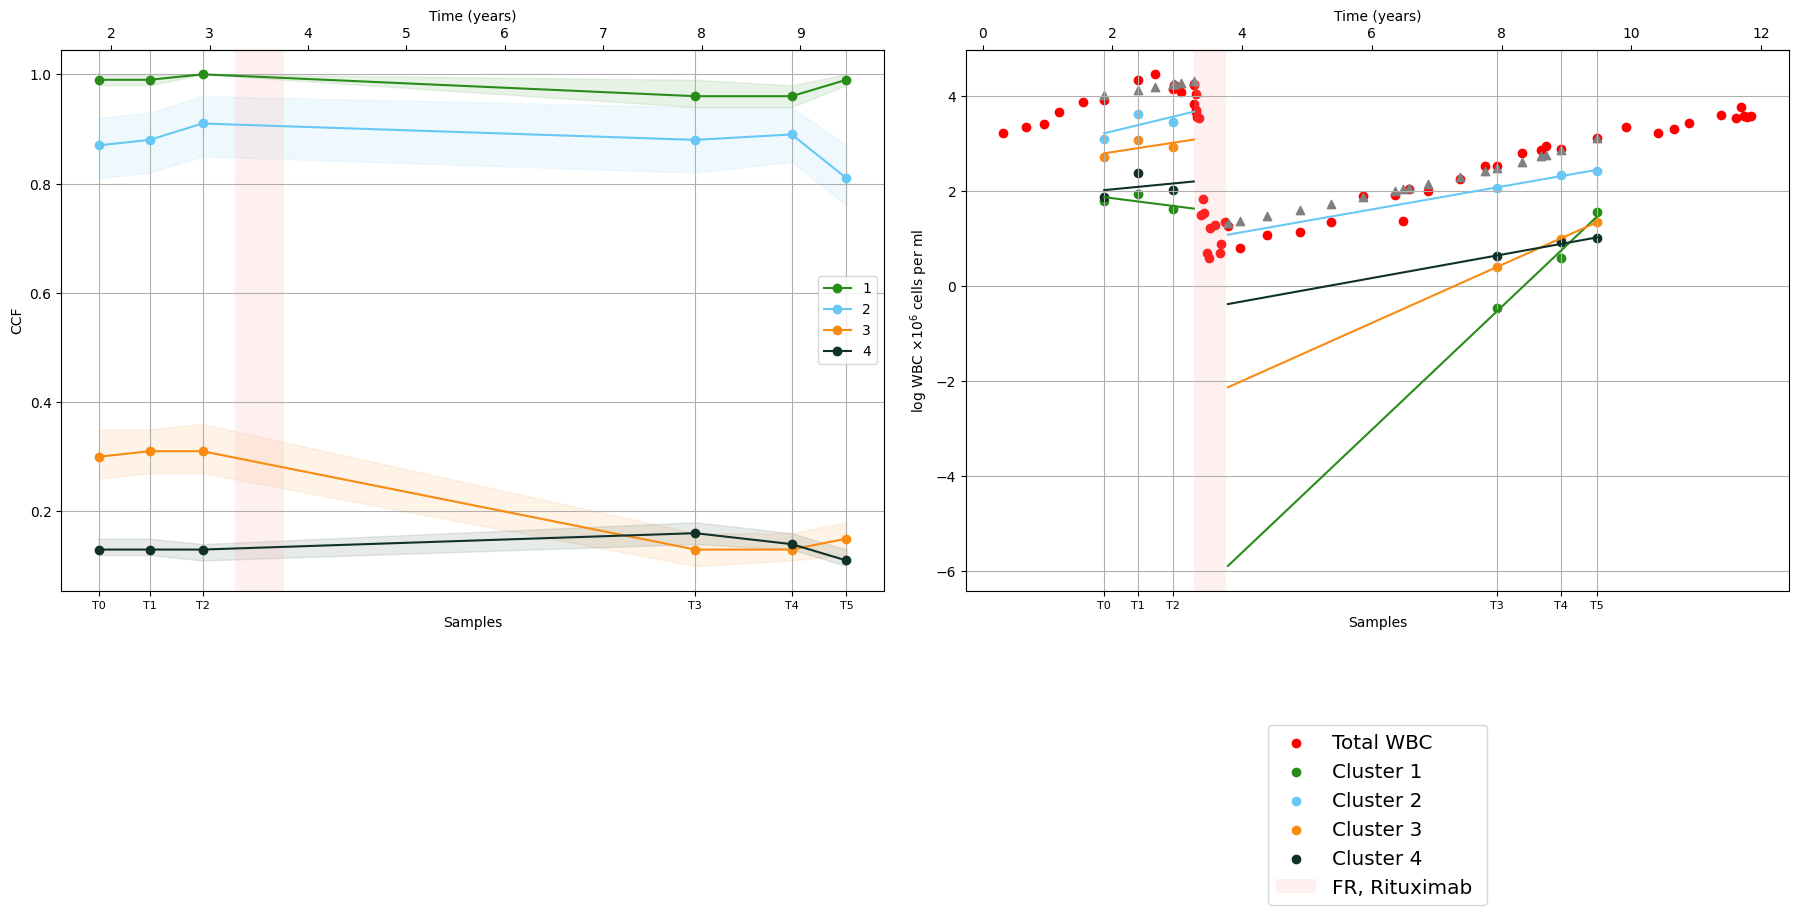

In [16]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =[times_sample[3], times_sample[4], times_sample[5]]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = [log_subclone_sample[i][3], log_subclone_sample[i][4], log_subclone_sample[i][5]]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_aft
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))


        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential

    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)
            



    
    cluster_cell_population = {}
    for i in clusters:
         # Extrapolate before treatment 

        extrapolate_times =[times_sample[0], times_sample[1], times_sample[2]]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = [log_subclone_sample[i][0], log_subclone_sample[i][1], log_subclone_sample[i][2]]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_bf
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential
    
    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub(ax2, [1,2,3, 4])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

In [18]:
# Linear Regression Modeling

In [32]:
from scipy.special import logsumexp 
from scipy.optimize import minimize

In [33]:
class MultiClusterLinearRegression:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.params = None

    def objective(self, params, X, y, logsumexp_points):
        # reshape params into intercepts and slopes
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]


        # calculate predicted y values for all clusters 
        y_pred = np.outer(X, slopes) + intercepts

        # Calcualte negative log-likelihood
        likelihood = 0

        # For exome points
        for i, yi in enumerate(y):
   
            if yi is not None:
                likelihood -= np.sum((yi - y_pred[i])**2)

        # For logsumexp points
        
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood -= (lse - logsumexp(y_pred[i]))**2

        return -likelihood  # We minimize negative log-likelihood



    def fit(self, X, y, logsumexp_points, initial_guess = None):

        if initial_guess is None:
            initial_guess = np.random.randn(2 * self.n_clusters)

        result = minimize(
            self.objective, 
            initial_guess,
            args = (X,y, logsumexp_points),
            method = 'SLSQP'
        )

        self.params = result.x 


        # y_model = model.predict(predict_year)



    def predict(self, X):
        intercepts = self.params[:self.n_clusters]
        slopes = self.params[self.n_clusters:]
        return np.outer(X, slopes) + intercepts
    


In [21]:
# Try the model on real data

In [39]:
n_clusters = 4


In [40]:
def create_inputs(times_sliced, log_subclone_sample_mcmc,iter, index_samples_model):
    
    X = [ i/365 for i in np.array(times_sliced)]
    
    
    # reconstruct the dictionary so that {iteration number: cluster number :[time]}
    log_subclone_cluster_iter = {}
    
    # Iterate through each cluster
    for cluster, iterations in log_subclone_sample_mcmc.items():
        # Iterate through each iteration in the cluster
        for iteration, value in iterations.items():
            # If the iteration is not in the new dict, add it
            if iteration not in log_subclone_cluster_iter:
                log_subclone_cluster_iter[iteration] = {}
            # Add the cluster and its value to this iteration
            log_subclone_cluster_iter[iteration][cluster] = value
    
    
    
    values = list(log_subclone_cluster_iter[iter].values())
    array = np.array(values)
    array_trans = array.T
    selected_sample = array_trans[index_samples_model]
    
    
    times_sample_selected = times_sample[index_samples_model]
    indices = [i for i, x in enumerate(times_sliced) if x in times_sample_selected]
    
    y = [None] * len(times_sliced)
    i = 0
    # Fill the rows that correspond with the exome points
    for index in indices: 
        y[index] = selected_sample[i]
        i +=1
    
    
    return X, y
    
    
    

In [41]:
X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc,2, slice(3,6))

In [42]:
logsumexp_points = np.log(wbc_sliced_aft)


In [43]:
model = MultiClusterLinearRegression(4)
model.fit(X, y, logsumexp_points)

In [44]:
print("Estimated parameters:")
print("Intercepts:", model.params[:n_clusters])
print("Slopes:", model.params[n_clusters:])

Estimated parameters:
Intercepts: [-13.52753025  -0.67271326  -4.99886654  -1.9536055 ]
Slopes: [1.57658949 0.34945994 0.65180883 0.32405535]


In [45]:


logsumexp_points_model = [logsumexp(yi) for yi in model.predict(X)]
logsumexp_points_model

[np.float64(0.9063321194725458),
 np.float64(0.9714530322306612),
 np.float64(1.1216062407993572),
 np.float64(1.300047382983159),
 np.float64(1.47287289869908),
 np.float64(1.654291549046232),
 np.float64(1.838028553139829),
 np.float64(1.879830570023468),
 np.float64(1.9177085523251565),
 np.float64(2.025072251777542),
 np.float64(2.217063846906803),
 np.float64(2.369789197600349),
 np.float64(2.4484259514476356),
 np.float64(2.6118680482085583),
 np.float64(2.7402980765134117),
 np.float64(2.777452700852765),
 np.float64(2.8890375944613984),
 np.float64(3.190301685391629)]

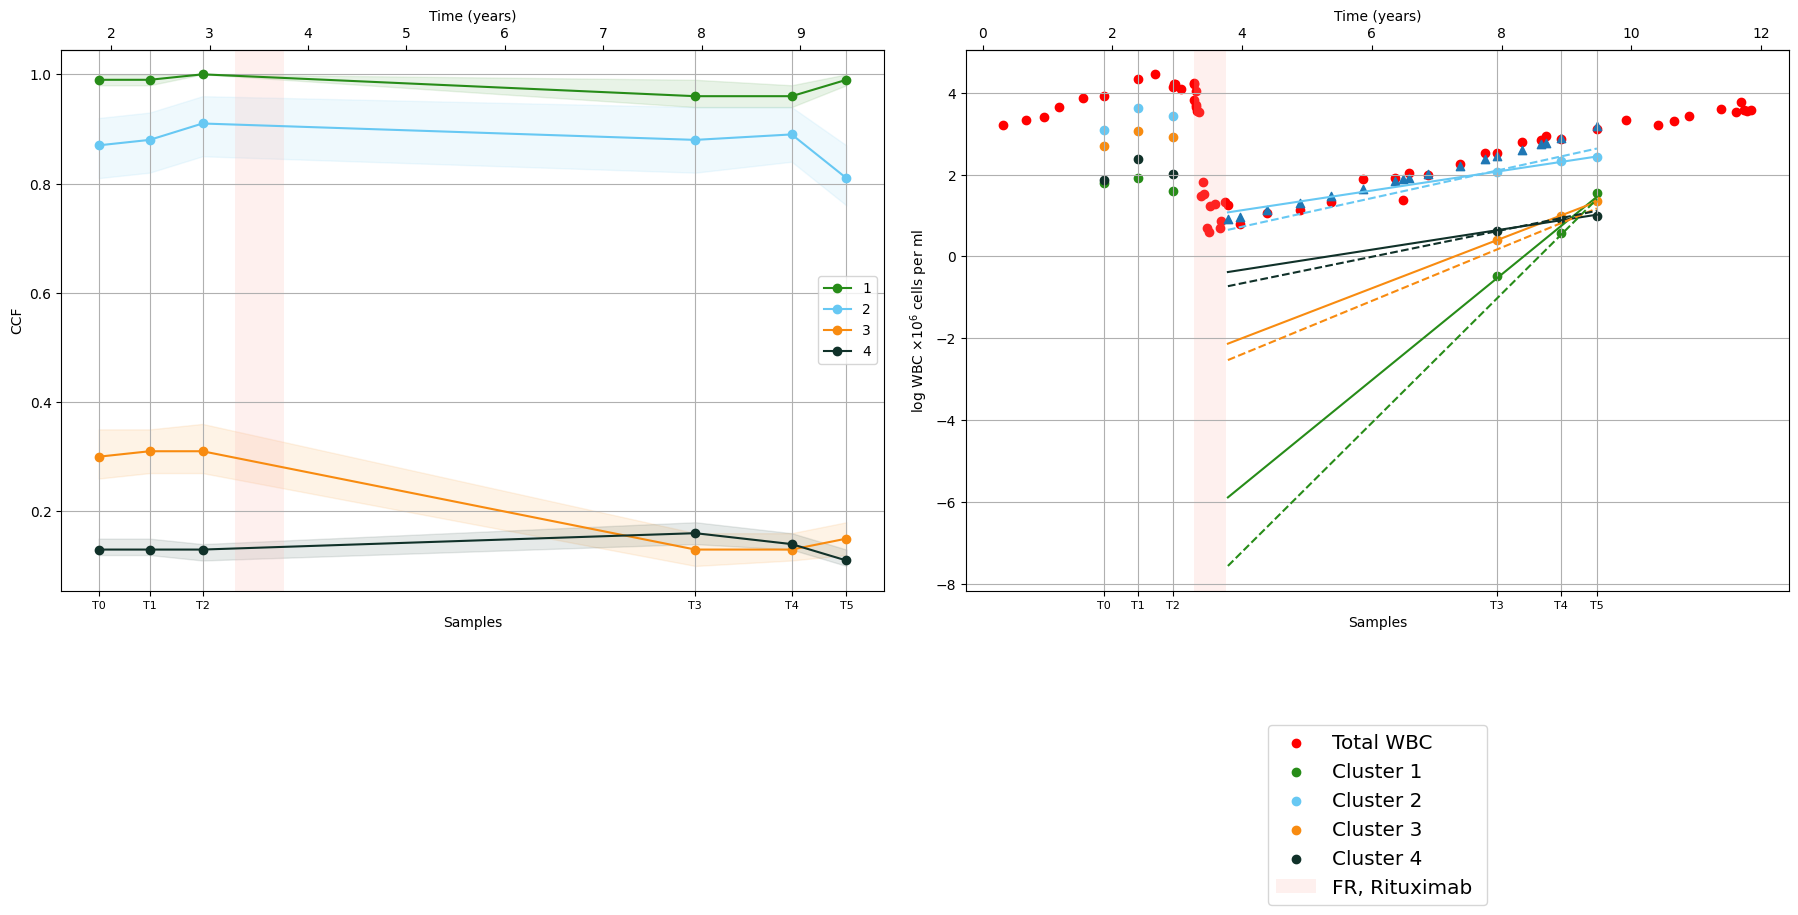

In [48]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_model_single_iter(ax, clusters, model):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    cluster_cell_population = {}

    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =[times_sample[3], times_sample[4], times_sample[5]]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = [log_subclone_sample[i][3], log_subclone_sample[i][4], log_subclone_sample[i][5]]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_aft
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))



        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential

    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    # plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)
            

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_model_single_iter(ax2, [1,2,3, 4], model)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for i in [1,2,3,4]:

    ax2.plot(X,model.predict(X)[:,i-1], '--', color=ClusterColors.get_hex_string(i))
ax2.scatter(X, logsumexp_points_model,marker='^')

In [ ]:
# Continue to model the T0-T2 period 

In [149]:
X, y = create_inputs(times_sliced_bf, log_subclone_sample_mcmc,0, slice(0,2))
logsumexp_points = np.log(wbc_sliced_bf)

In [150]:
model = MultiClusterLinearRegression(4)
model.fit(X, y, logsumexp_points)

In [151]:


logsumexp_points_model = [logsumexp(yi) for yi in model.predict(X)]
logsumexp_points_model

[np.float64(4.032767934440284),
 np.float64(4.1353595288797855),
 np.float64(4.193584280177822),
 np.float64(4.255385145533777),
 np.float64(4.261896931102992),
 np.float64(4.2645124342488545),
 np.float64(4.284992636425496),
 np.float64(4.335402839391184)]

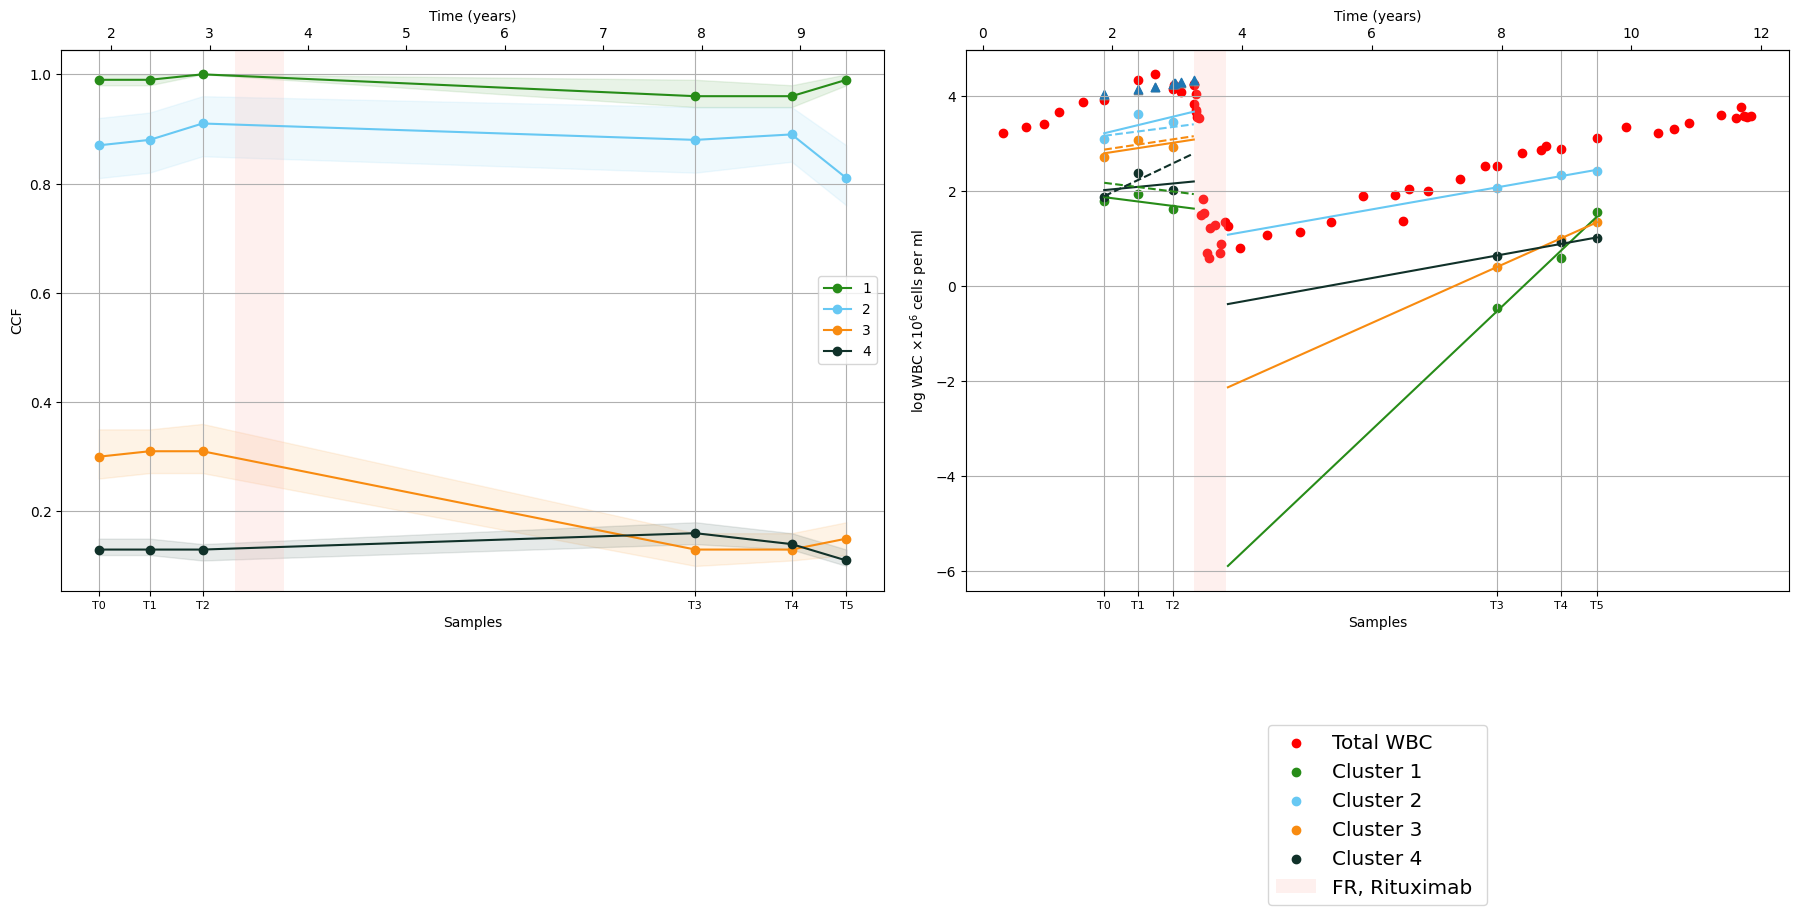

In [159]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, clusters, model):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}

    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =[times_sample[3], times_sample[4], times_sample[5]]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = [log_subclone_sample[i][3], log_subclone_sample[i][4], log_subclone_sample[i][5]]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_2
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))



        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential

    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    # plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)
            



    
    cluster_cell_population = {}
    for i in clusters:
         # Extrapolate before treatment 

        extrapolate_times =[times_sample[0], times_sample[1], times_sample[2]]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = [log_subclone_sample[i][0], log_subclone_sample[i][1], log_subclone_sample[i][2]]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_1
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential
    
    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub(ax2, [1,2,3, 4], model)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for i in [1,2,3,4]:

    ax2.plot(X,model.predict(X)[:,i-1], '--', color=ClusterColors.get_hex_string(i))
ax2.scatter(X, logsumexp_points_model,marker='^')

In [292]:
# Add in mcmc iterations

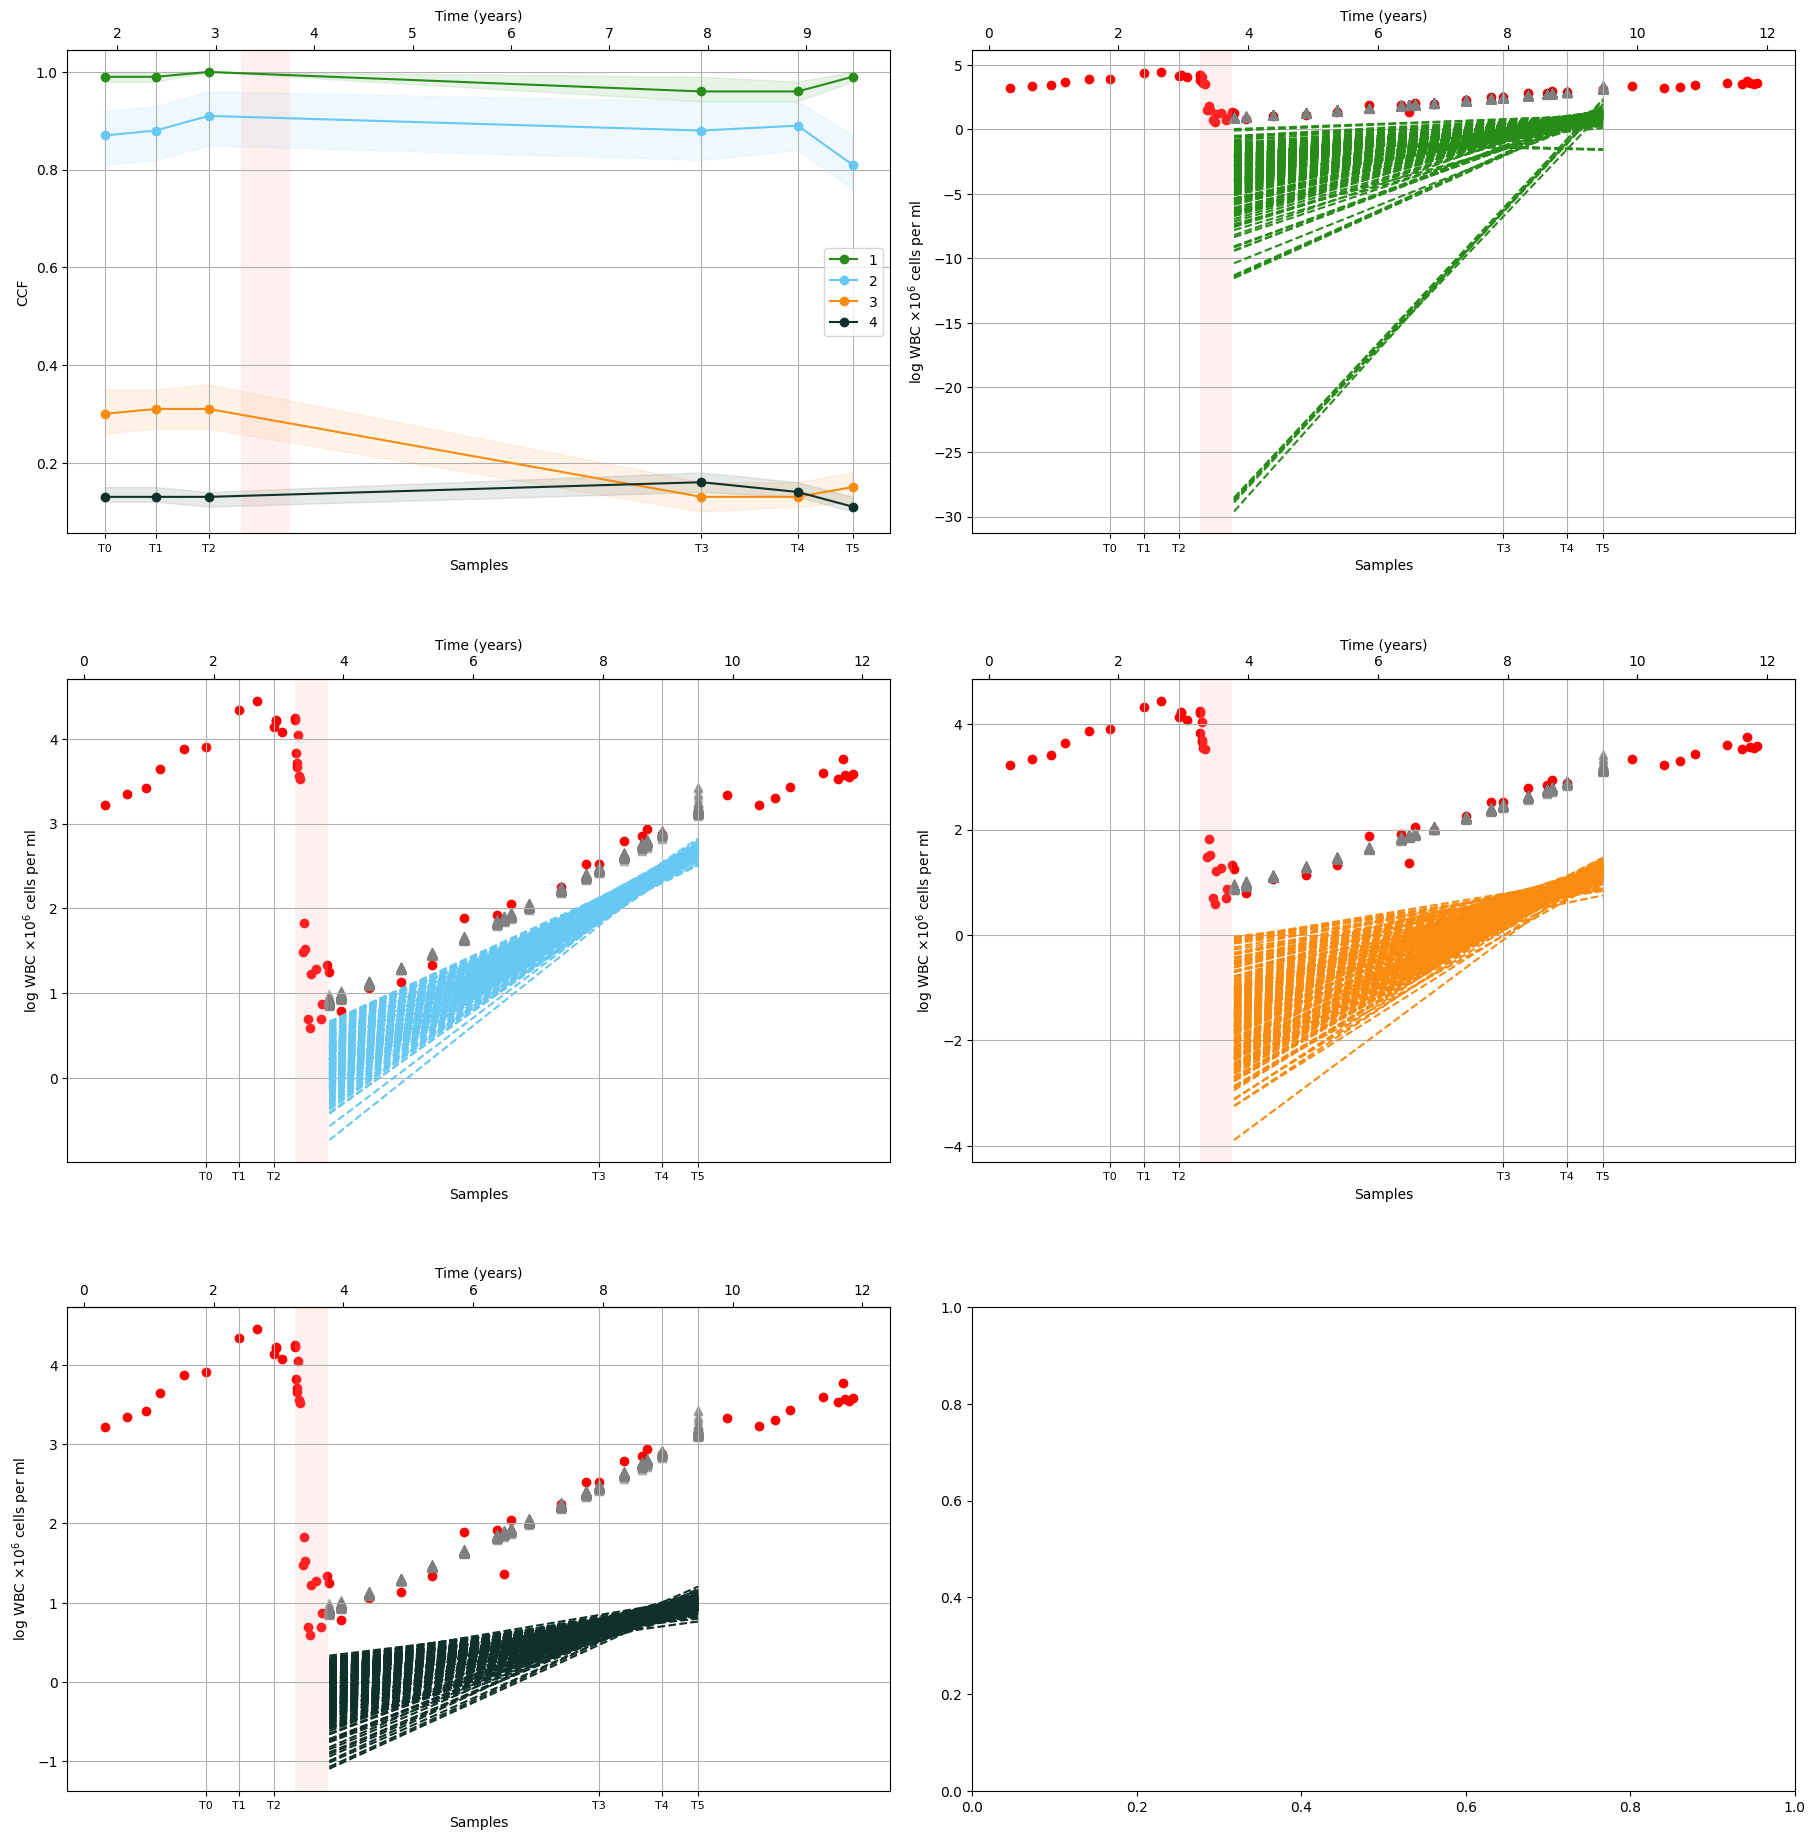

In [162]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]



X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc,iter_idx, index_samples_model)
logsumexp_points = np.log(wbc_sliced_aft)
def plot_mcmc_model(ax, cluster, n_clusters,index_samples_model, X, y,logsumexp_points ):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}


    for iter_idx in range(250):
        
        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters)

        
        

        
        model.fit(X, y, logsumexp_points )
        

        ax.plot(X,model.predict(X)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            


        logsumexp_points_model = [logsumexp(yi) for yi in model.predict(X)]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
        ax.scatter(X, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_mcmc_model(ax2, 1, n_clusters = 4, index_samples_model = slice(3,6))
plot_mcmc_model(ax3, 2, n_clusters = 4, index_samples_model = slice(3,6))
plot_mcmc_model(ax4, 3, n_clusters = 4, index_samples_model = slice(3,6))
plot_mcmc_model(ax5, 4, n_clusters = 4, index_samples_model = slice(3,6))

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




# ax2.plot(predict_year,model.predict(predict_year)[:,i-1], '--', color=ClusterColors.get_hex_string(i))
# ax2.scatter(predict_year, logsumexp_points_model,marker='^')

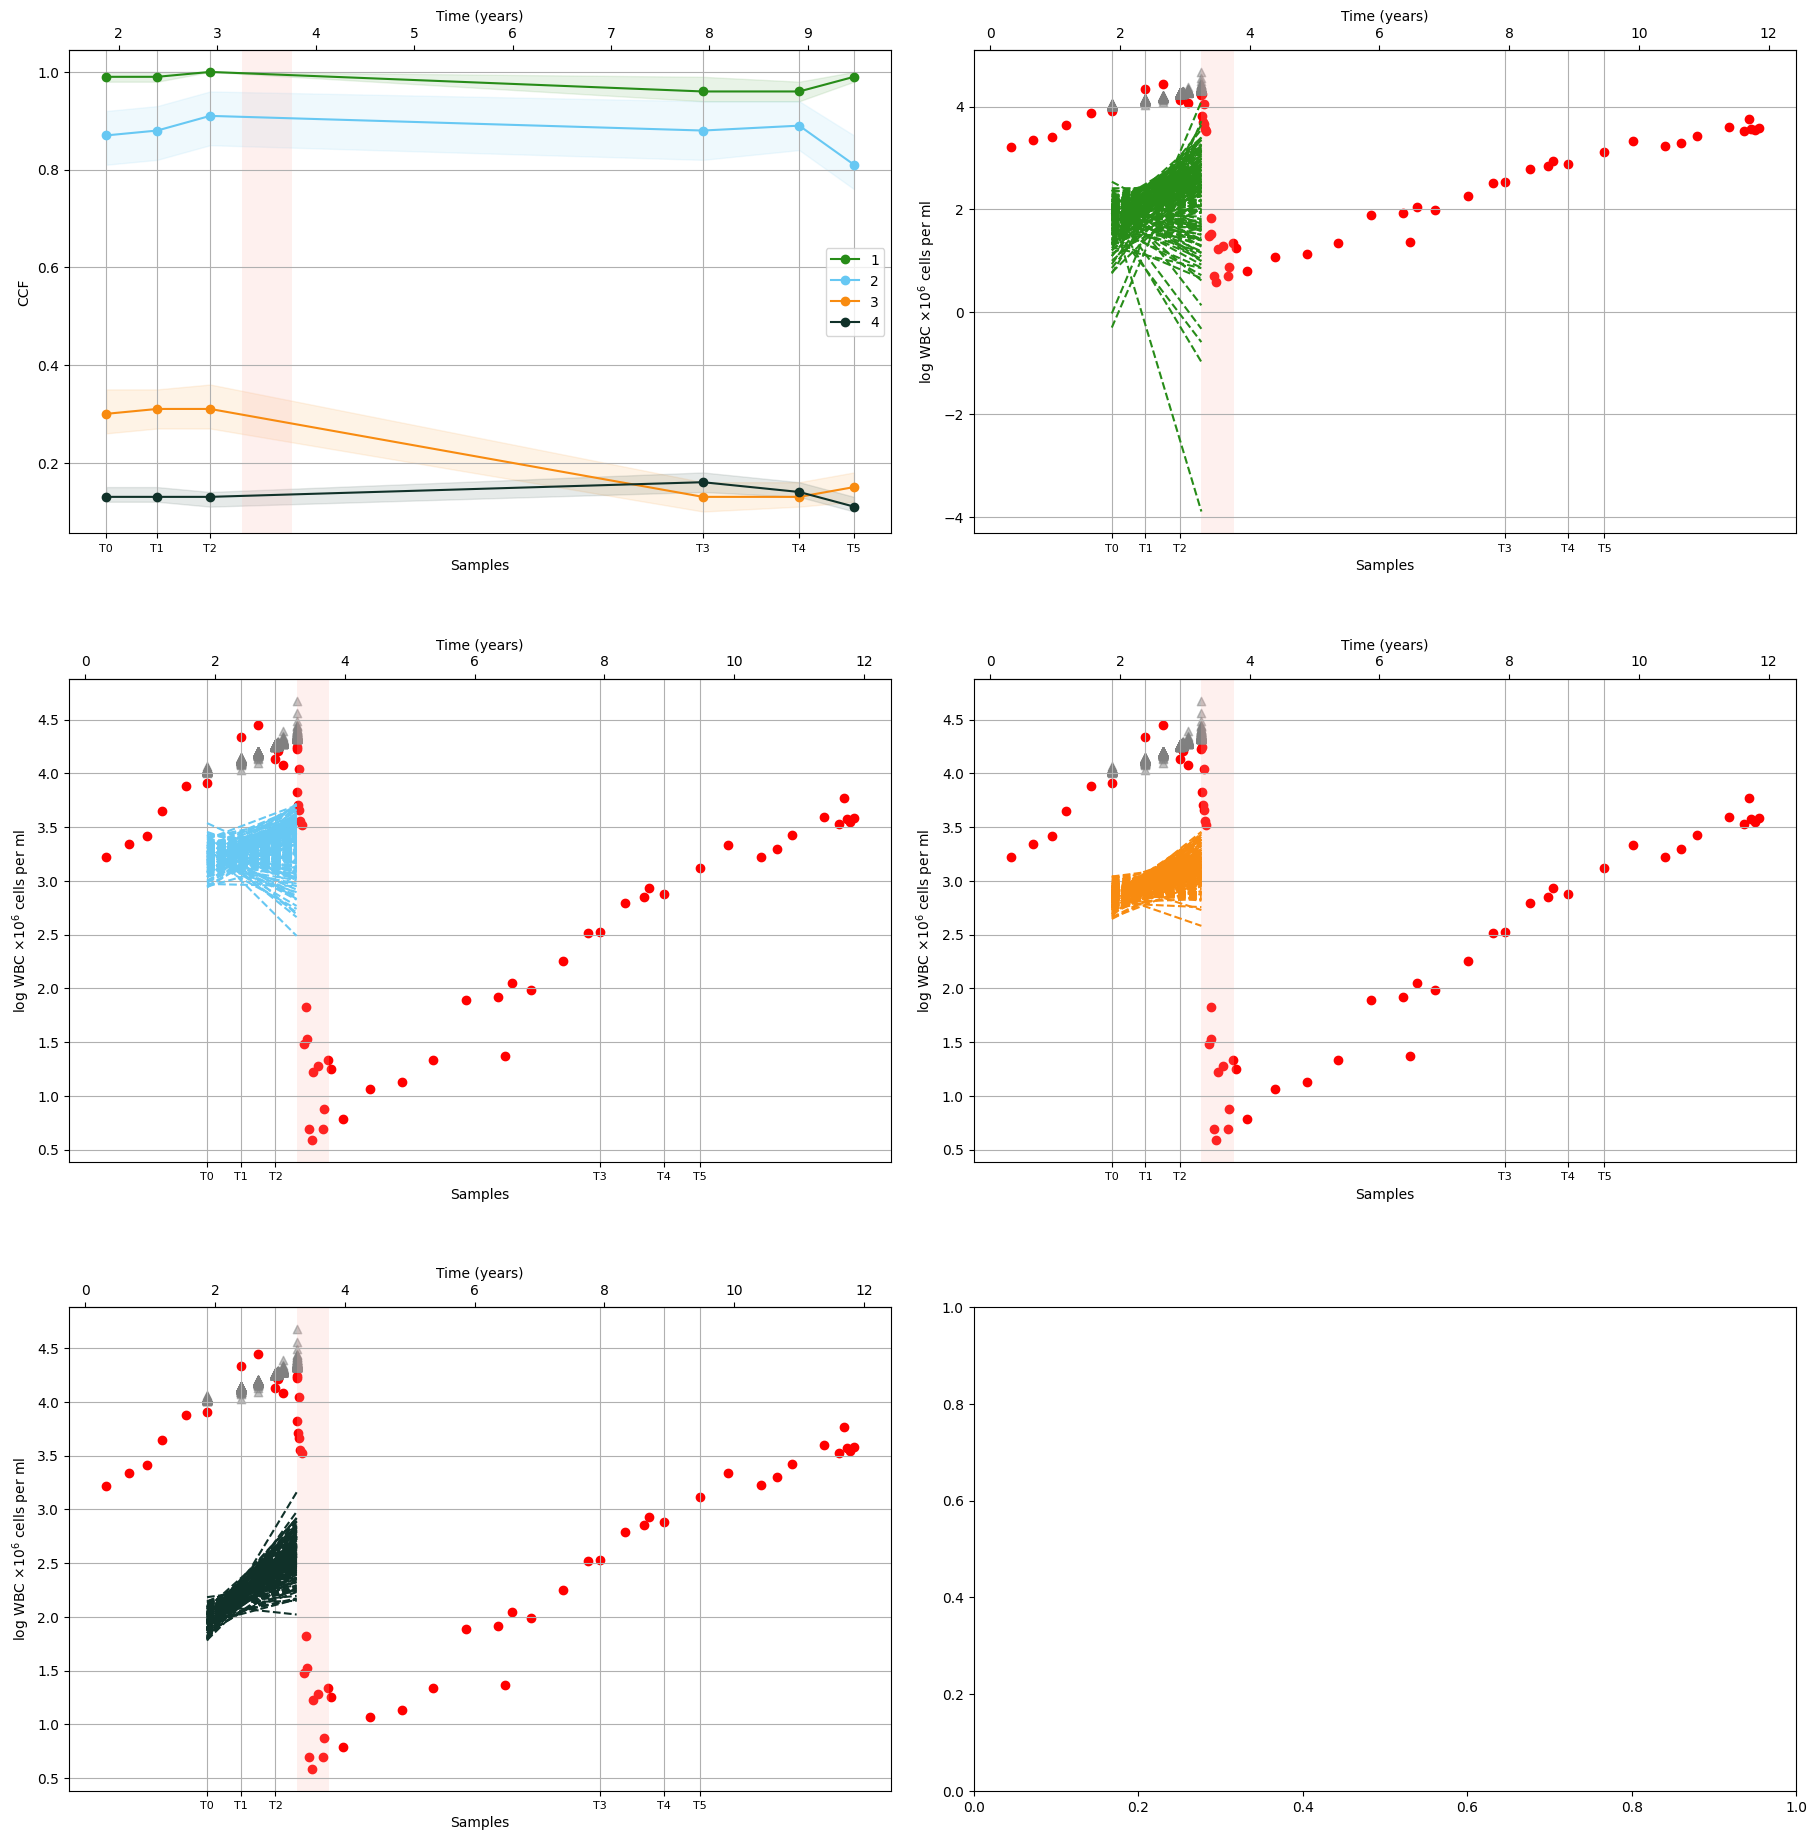

In [168]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]




def plot_mcmc_model(ax, cluster, n_clusters,index_samples_model, times_sliced, wbc_sliced ):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}


    for iter_idx in range(250):
        
        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters)

        
        X, y = create_inputs(times_sliced, log_subclone_sample_mcmc,iter_idx, index_samples_model)
        logsumexp_points = np.log(wbc_sliced)

        
        model.fit(X, y, logsumexp_points )
        

        ax.plot(X,model.predict(X)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            


        logsumexp_points_model = [logsumexp(yi) for yi in model.predict(X)]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
        ax.scatter(X, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_mcmc_model(ax2, 1, 4, slice(0,2), times_sliced_bf, wbc_sliced_bf)
plot_mcmc_model(ax3, 2, 4, slice(0,2), times_sliced_bf, wbc_sliced_bf)
plot_mcmc_model(ax4, 3, 4, slice(0,2), times_sliced_bf, wbc_sliced_bf)
plot_mcmc_model(ax5, 4, 4, slice(0,2), times_sliced_bf, wbc_sliced_bf)

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




# ax2.plot(predict_year,model.predict(predict_year)[:,i-1], '--', color=ClusterColors.get_hex_string(i))
# ax2.scatter(predict_year, logsumexp_points_model,marker='^')

In [280]:
# Model with different weights

In [84]:
class MultiClusterLinearRegression:
    def __init__(self, n_clusters,X, y):
        self.n_clusters = n_clusters
        self.params = None
        self.X = X
        self.y = y
        
        
    def calculate_weight_ratio(self ):
        num_wbc = len(self.y)
        num_exomes = sum(1 for item in self.y if item is not None)
        
        weight_ratio = num_wbc / ((num_exomes)*(self.n_clusters -1))
        return weight_ratio
        

    def objective(self, params, logsumexp_points, ):
        # reshape params into intercepts and slopes
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]

        weight_ratio = self.calculate_weight_ratio()
        
        # calculate predicted y values for all clusters 
        y_pred = np.outer(self.X, slopes) + intercepts

        # Calcualte negative log-likelihood
        likelihood = 0

        # For exome points
        for i, yi in enumerate(self.y):
   
            if yi is not None:
                likelihood +=  weight_ratio * np.sum((yi - y_pred[i])**2)

        # For logsumexp points
        
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood += (lse - logsumexp(y_pred[i]))**2

        return likelihood  # We minimize negative log-likelihood



    def fit(self, logsumexp_points, initial_guess = None):

        if initial_guess is None:
            initial_guess = np.random.randn(2 * self.n_clusters)

        result = minimize(
            self.objective, 
            initial_guess,
            args = (logsumexp_points),
            method = 'SLSQP'
        )

        self.params = result.x 




        
        
    def calculate_likelihood(self, params, logsumexp_points):
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]
        y_pred = np.outer(self.X, slopes) + intercepts
        
        likelihood_y = 0
        for i, yi in enumerate(self.y):
            if yi is not None:
                likelihood_y += np.sum((yi - y_pred[i])**2)
                print(f"exome logsubclone: {yi},exome predicted: {y_pred[i]}")
        
       
        print(f"squared sum_y: {likelihood_y}")
        
        
        likelihood_logsumexp = 0 
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood_logsumexp += (lse - logsumexp(y_pred[i]))**2
                print(f"log wbc: {lse},wbc predicted: {logsumexp(y_pred[i])}")
        print(f"squared sum_logsumexp: {likelihood_logsumexp}")
        
        total_squared_sum = likelihood_y + likelihood_logsumexp
    
        print(f"total squared sum: {total_squared_sum}")
        return likelihood_y, likelihood_logsumexp
    


    def predict(self,):
        intercepts = self.params[:self.n_clusters]
        slopes = self.params[self.n_clusters:]
        return np.outer(self.X, slopes) + intercepts
    


In [85]:
X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc,0, slice(3,6))
logsumexp_points = np.log(wbc_sliced_aft)

In [86]:
model = MultiClusterLinearRegression(4,X, y)
model.fit(logsumexp_points)

In [87]:
model.calculate_weight_ratio()

2.0

In [88]:
model.params

array([-11.35948123,  -1.33696035,  -2.41503128,  -1.02416977,
         1.31827873,   0.42295053,   0.37002561,   0.21665824])

In [366]:
# Change the weight for exome points


weights = [0.1,1, 2, 10,50, 100]

likelihood_y_weights = []
likelihood_logsumexp_weights = []
total_squared_sum_weights = []

for i in weights:
    model = MultiClusterLinearRegression(n_clusters =4,y_weight= i, logsumexp_weight=1)
    model.fit(X, y, logsumexp_points )
    likelihood_y, likelihood_logsumexp = model.calculate_likelihood(model.params, X, y, logsumexp_points)

    
    total_squared_sum = likelihood_y + likelihood_logsumexp
    
    likelihood_y_weights.append(likelihood_y)
    likelihood_logsumexp_weights.append(likelihood_logsumexp)
    total_squared_sum_weights.append(total_squared_sum)
    
    print(f"Estimated parameters for y_weight {i}")
#     print("Intercepts:", model.params[:n_clusters])
    print("Slopes:", model.params[n_clusters:])
    print("\n")

exome logsubclone: [-0.97750146  2.07959778  0.48627675  0.69377199],exome predicted: [-0.80701093  2.04397154  0.48344013  0.79065591]
exome logsubclone: [0.57761286 2.26319749 0.98274492 0.91379963],exome predicted: [0.36409823 2.55249649 0.91079605 0.90027973]
exome logsubclone: [0.99851936 2.65607316 0.99851936 0.99851936],exome predicted: [1.03002305 2.84165773 1.15380236 0.96261484]
squared sum_y: 0.2352086922542573
log wbc: 1.252762968495368,wbc predicted: 0.9330993758523979
log wbc: 0.7884573603642703,wbc predicted: 0.9870044509852487
log wbc: 1.0647107369924282,wbc predicted: 1.1159571992678063
log wbc: 1.1314021114911006,wbc predicted: 1.2775522022272248
log wbc: 1.33500106673234,wbc predicted: 1.4424003419132634
log wbc: 1.8870696490323797,wbc predicted: 1.6236872187093176
log wbc: 1.916922612182061,wbc predicted: 1.814969745727283
log wbc: 1.366091653802371,wbc predicted: 1.859437261863909
log wbc: 2.046401687601636,wbc predicted: 1.900001198740964
log wbc: 1.98787434815434

exome logsubclone: [-0.97750146  2.07959778  0.48627675  0.69377199],exome predicted: [-0.90775324  2.02104673  0.52278075  0.69310268]
exome logsubclone: [0.57761286 2.26319749 0.98274492 0.91379963],exome predicted: [0.38566098 2.38456365 0.87266006 0.89758257]
exome logsubclone: [0.99851936 2.65607316 0.99851936 0.99851936],exome predicted: [1.12113181 2.59126935 1.07161103 1.01385545]
squared sum_y: 0.0983939089634956
log wbc: 1.252762968495368,wbc predicted: 1.041872549156894
log wbc: 0.7884573603642703,wbc predicted: 1.101116011902354
log wbc: 1.0647107369924282,wbc predicted: 1.238057082946277
log wbc: 1.1314021114911006,wbc predicted: 1.4013278146028472
log wbc: 1.33500106673234,wbc predicted: 1.5598926798123434
log wbc: 1.8870696490323797,wbc predicted: 1.726656531742757
log wbc: 1.916922612182061,wbc predicted: 1.8957017960666382
log wbc: 1.366091653802371,wbc predicted: 1.9341588178519895
log wbc: 2.046401687601636,wbc predicted: 1.96899893545983
log wbc: 1.9878743481543455,

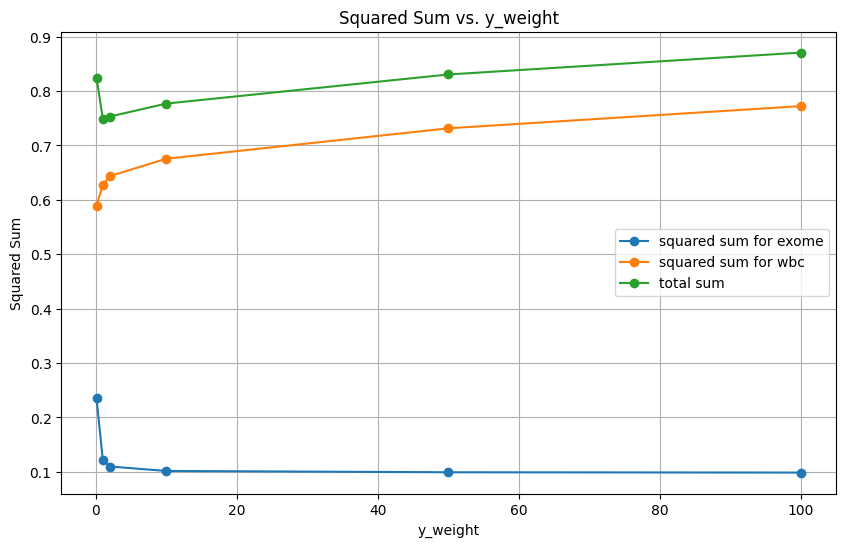

In [370]:
plt.figure(figsize=(10, 6))
plt.plot(weights, likelihood_y_weights, marker='o', label = "squared sum for exome")
plt.plot(weights, likelihood_logsumexp_weights, marker='o', label = "squared sum for wbc")
plt.plot(weights, total_squared_sum_weights, marker='o', label = "total sum")

plt.title('Squared Sum vs. y_weight')
plt.xlabel('y_weight')
plt.ylabel('Squared Sum')
plt.legend() 
plt.grid(True)
plt.show()

In [355]:
model.params

array([-11.38908177,  -1.22128937,  -2.39326277,  -1.08154571,
         1.32137165,   0.40681725,   0.36694203,   0.22256113])

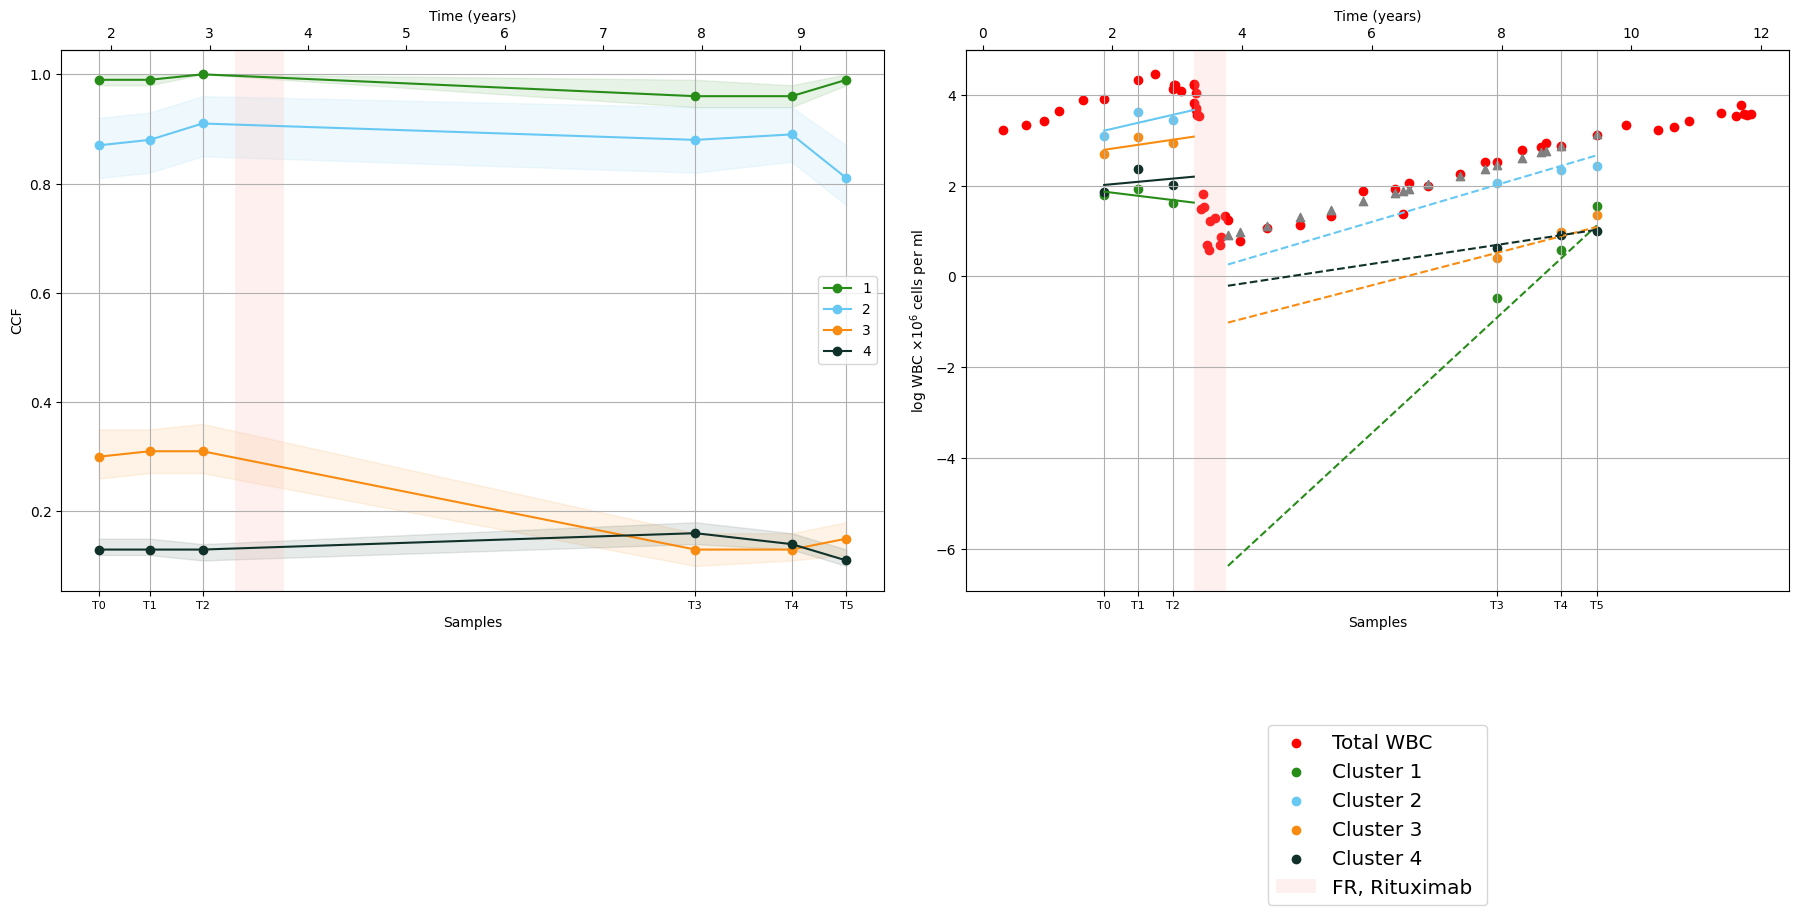

In [369]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, clusters, model):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}

    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =[times_sample[3], times_sample[4], times_sample[5]]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = [log_subclone_sample[i][3], log_subclone_sample[i][4], log_subclone_sample[i][5]]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_2
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
#         plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))



        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential

    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    # plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)
            



    
    cluster_cell_population = {}
    for i in clusters:
         # Extrapolate before treatment 

        extrapolate_times =[times_sample[0], times_sample[1], times_sample[2]]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = [log_subclone_sample[i][0], log_subclone_sample[i][1], log_subclone_sample[i][2]]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_1
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential
    
    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
#     plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub(ax2, [1,2,3, 4], model)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for weight in [2]:
    model = MultiClusterLinearRegression(n_clusters =4,y_weight=weight, logsumexp_weight=1.0)
    model.fit(X, y, logsumexp_points )
    logsumexp_points_model = [logsumexp(yi) for yi in model.predict(X)]

    for i in [1,2,3,4]:

        ax2.plot(X,model.predict(X)[:,i-1], '--', color=ClusterColors.get_hex_string(i))
    ax2.scatter(X, logsumexp_points_model,marker='^', color = 'grey')